In [1]:
#you may need to run this
!pip install torch
!pip install open_clip_torch
!pip install numpy
!pip install pandas
!pip install Pillow

In [2]:
#imports
import torch
import open_clip
import numpy as np
import pandas as pd
from PIL import Image

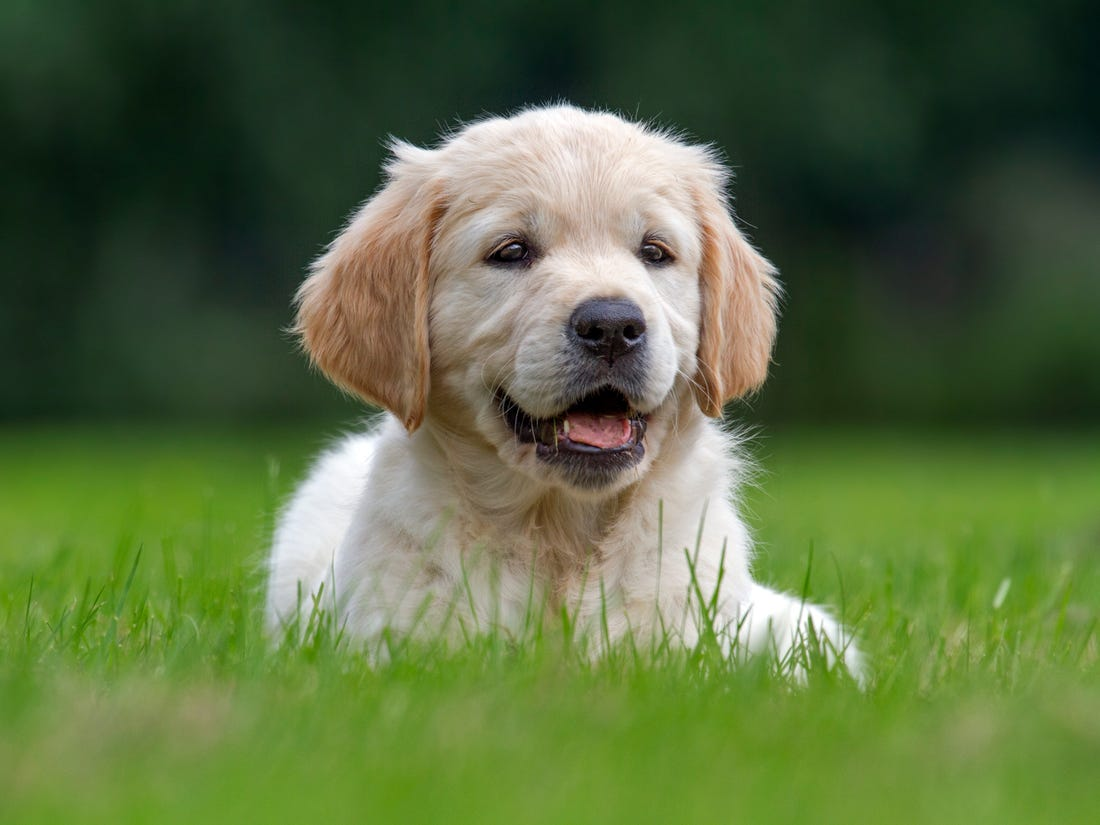

In [3]:
#load image
img_path = "Dog_Breeds.jpg"
img = Image.open(img_path)
display(img)

In [4]:
#instantiate model and tokenizer
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [5]:
#preprocess image
image = preprocess(img).unsqueeze(0)
#potential descriptions (try adding/removing some!)
labels = ["a cow", "happy", "a dog", "grass", "a happy dog", "a sad dog", "human", "banana", "wild", "new york"]
text = tokenizer(labels)

#no_grad disables gradient calculation 
with torch.no_grad():#, torch.amp.autocast():
    #encode image
    image_features = model.encode_image(image)
    #encode text
    text_features = model.encode_text(text)

    #normalize each
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    #cosine similarity of image with each potential description
    #+softmax to turn into probabilities
    cosine_sims = image_features @ text_features.T
    text_probs = (100.0 * cosine_sims).softmax(dim=-1)

#let's see how we did...
results = pd.DataFrame(np.zeros((2, len(labels))))
results.columns = labels
results.index = ["Cosine Similarity", "Probability"]
results.iloc[0] = cosine_sims[0].tolist()
results.iloc[1] = list(map(lambda x : round(x, 6), text_probs[0].tolist()))

print(results)
print("-"*70)
print(f"The image is most likely -- {sorted(list(results.columns), key = lambda x : results.iloc[1].iloc[list(results.columns).index(x)])[-1]}")


                      a cow     happy     a dog     grass  a happy dog  \
Cosine Similarity  0.136484  0.246335  0.274273  0.242533     0.322443   
Probability        0.000000  0.000491  0.008018  0.000335     0.990988   

                   a sad dog     human    banana      wild  new york  
Cosine Similarity   0.232356  0.190813  0.203184  0.218583  0.203509  
Probability         0.000121  0.000002  0.000007  0.000031  0.000007  
----------------------------------------------------------------------
The image is most likely -- a happy dog


In [19]:
#quick proof of concept with the CIFAR100 test set
#(warning: this will take 5-15 minutes if you want to run it yourself)

In [7]:
import torchvision
import torchvision.transforms as transforms
import heapq

Processed 2000/10000 images
Processed 4000/10000 images
Processed 6000/10000 images
Processed 8000/10000 images
Processed 10000/10000 images


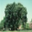

Similarity: 0.29824262857437134


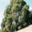

Similarity: 0.2968382239341736


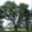

Similarity: 0.29295802116394043


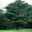

Similarity: 0.2928447425365448


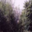

Similarity: 0.2922918200492859


In [14]:
CIFARtestset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)

query = "trees"
text = tokenizer(query)

topFive = []

#no_grad disables gradient calculation 
with torch.no_grad():#, torch.amp.autocast('cuda'):
    #encode text
    text_features = model.encode_text(text)

    num = 0
    for PIL_image, label in CIFARtestset:
        image = preprocess(PIL_image).unsqueeze(0)
        #encode image
        image_features = model.encode_image(image)
    
        #normalize each
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
        #cosine sim with the text embedding
        cosine_sim = (image_features @ text_features.T)[0][0]

        #add to the heap (this imp automatically uses the first val of the tuple as the key
        if len(topFive) < 5:
            heapq.heappush(topFive, (cosine_sim, PIL_image))
        else:
            heapq.heappushpop(topFive, (cosine_sim, PIL_image))

        #so you know something is happening...
        num += 1
        if num % 2000 == 0:
            print(f"Processed {num}/10000 images")

#show best matches
for simVal, img in sorted(topFive, key = lambda x : x[0])[::-1]:
    display(img)
    print(f"Similarity: {simVal}")


Processed 2000/10000 images
Processed 4000/10000 images
Processed 6000/10000 images
Processed 8000/10000 images
Processed 10000/10000 images


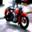

Similarity: 0.3100479245185852


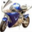

Similarity: 0.3079091012477875


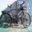

Similarity: 0.30390071868896484


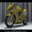

Similarity: 0.30015841126441956


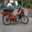

Similarity: 0.2973695397377014


In [16]:
CIFARtestset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)

query = "motorcycle"
text = tokenizer(query)

topFive = []

#no_grad disables gradient calculation 
with torch.no_grad():#, torch.amp.autocast('cuda'):
    #encode text
    text_features = model.encode_text(text)

    num = 0
    for PIL_image, label in CIFARtestset:
        image = preprocess(PIL_image).unsqueeze(0)
        #encode image
        image_features = model.encode_image(image)
    
        #normalize each
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
        #cosine sim with the text embedding
        cosine_sim = (image_features @ text_features.T)[0][0]

        #add to the heap (this imp automatically uses the first val of the tuple as the key
        if len(topFive) < 5:
            heapq.heappush(topFive, (cosine_sim, PIL_image))
        else:
            heapq.heappushpop(topFive, (cosine_sim, PIL_image))

        #so you know something is happening...
        num += 1
        if num % 2000 == 0:
            print(f"Processed {num}/10000 images")

#show best matches
for simVal, img in sorted(topFive, key = lambda x : x[0])[::-1]:
    display(img)
    print(f"Similarity: {simVal}")
